In [4]:
import requests
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from natsort import index_natsorted
import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""Retrieving all the data from a website"""

number = 0
link = requests.get('https://fcd.terra.dev/v1/txs?offset='+str(number)+'&limit=100&account=terra1f89xq3qhu98v4jch4y5xcrkhl9gytrne99x74t')
counter = 0
lista_slownikow = []
while True:
    try:
        next_number_txt = link.text[link.text.find('next'):link.text.find('limit')]
        number = re.findall('\d+', next_number_txt)[0]
        link = requests.get('https://fcd.terra.dev/v1/txs?offset='+str(number)+'&limit=100&account=terra1f89xq3qhu98v4jch4y5xcrkhl9gytrne99x74t')
        lista_jsonow = link.json()
        for i in range(100):
            msg_dic = {}
            messages = lista_jsonow['txs'][i]['tx']['value']['msg']           
            for message in messages:
                relevant_messages = []
                if 'execute_msg' in message['value'].keys():
                    relevant_messages.append(message)
                msg_dic['type'] = relevant_messages[0]['type']
                msg_dic['hash_id'] = lista_jsonow['txs'][0]['txhash']
                msg_dic['exe_msg'] = relevant_messages[0]['value']['execute_msg']

        
            lista_slownikow.append(msg_dic)
        counter = counter + 1
        print(counter)
    except:
        time.sleep(60*0.1)

In [5]:
"""Saving the data into .txt file"""

with open('Lista2AoUd.txt', 'w') as f:
    f.write(str(lista_slownikow))

In [1]:
"""Loading the data from .txt file"""

f = open("Lista2AoUd.txt", "r")
lista_slownikow2 = eval(f.read())

In [2]:
"""Creating a list of dictionaries with records which have mint_nft inside of them"""

lista_slownikow = lista_slownikow2
dictionary_list_with_mint_nft = []
for i in lista_slownikow:
    if 'mint_nft' in i['exe_msg']:
        dictionary_list_with_mint_nft.append(i)

In [5]:
"""Creation of dictionary that includes traits from those with mint_nft, also including Name and token_id"""

characteristics_dict = {'Background':[], 'Skin':[], 'Shell':[], 'Body':[],  'Mouth':[], 'Eyes':[], 'Head':[]}
names = []
ids = []
for i in range(len(dictionary_list_with_mint_nft)):
    traits = dictionary_list_with_mint_nft[i]['exe_msg']['mint_nft']['extension']['attributes']
    names.append(dictionary_list_with_mint_nft[i]['exe_msg']['mint_nft']['extension']['name'])
    ids.append(dictionary_list_with_mint_nft[i]['exe_msg']['mint_nft']['token_id'])
    for j in range(len(traits)):
        characteristics_dict[str(traits[j]['trait_type'])].append(traits[j]['value'])
df = pd.DataFrame(data=characteristics_dict)
df.insert(0, 'Name', names)
df.insert(1, 'token_id',ids)

In [6]:
"""Creation of transaction list of lists"""

transactions = []
for i in range(len(lista_slownikow)):   
    to_add = []
    try:        
        for key, value in lista_slownikow[i]['exe_msg'].items():
            b = key
        #print(b)
        to_add.append(lista_slownikow[i]['exe_msg'][str(b)]['order']['order']['maker_asset']['info']['nft']['token_id'])
        to_add.append(lista_slownikow[i]['exe_msg'][str(b)]['order']['order']['maker_asset']['info']['nft']['contract_addr'])
        to_add.append(lista_slownikow[i]['exe_msg'][str(b)]['order']['order']['maker_asset']['amount'])
        to_add.append(lista_slownikow[i]['exe_msg'][str(b)]['order']['order']['taker_asset']['info']['native_token']['denom'])
        to_add.append(lista_slownikow[i]['exe_msg'][str(b)]['order']['order']['taker_asset']['amount'])  
        transactions.append(to_add)
    except:
        pass

In [7]:
"""Creation of transactions dataframe"""

df_transactions = pd.DataFrame(data=transactions)
df_transactions.columns=['token_id','contact address','amount','currency','price']
df_transactions['price'] = df_transactions['price'].astype(float)
df_transactions['Price_in_luna'] = pd.Series(df_transactions['price']/1000000, index=df_transactions.index)

In [8]:
"""Calculating rarity score for each row of traits and assinging rank to it"""

values_count = []
for k in characteristics_dict.keys():
    values_count.append(df[str(k)].value_counts())
list_of_scores = np.zeros(len(df))
num = 0
df_names = list(df)
df_names = df_names[2:len(df_names)]

for k in df_names:
    for j in range(len(df)):
        list_of_scores[j] += values_count[num][df[str(df_names[num])][j]]/len(df)
    num+=1    
df['Rarity score'] = pd.Series(list_of_scores, index=df.index)
ranks = range(1,len(df)+1)
df_sorted = df.sort_values(['Rarity score'])
df_sorted['Rank'] = pd.Series(ranks, index=df_sorted.index)
df = df_sorted.sort_index()

In [18]:
background = df['Background'].value_counts()
skin = df['Skin'].value_counts()
shell = df['Shell'].value_counts()
mouth = df['Mouth'].value_counts()
body = df['Body'].value_counts()
eyes = df['Eyes'].value_counts()
head = df['Head'].value_counts()
na_values = df.isna()
na_columns = na_values.any()
print(skin)

Common              269
Lion                155
Luna                118
Hellfire             63
Geisha               63
Teddy                56
Tiger Teddy          55
Chocolate            50
Black and Yellow     43
Leopard Unicorn      41
Leopard Lion         31
Tiger                30
Monochrome           22
Zebra                20
Unicorn              19
Dalmation            14
Frog                 12
Rainbow              10
Zombie                7
Name: Skin, dtype: int64


In [9]:
def n_gram(column, words_from, words_to):
    """Function returns frequency of appearing of word sentences consisting of n words"""
    
    word_vectorizer = CountVectorizer(ngram_range=(words_from, words_to), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(df[str(column)])
    frequencies = sum(sparse_matrix).toarray()[0]
    to_return = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
    return to_return

n_gram('Eyes',2,3)
#n_gram('Body',2,2)

,frequency
angry clown,25
angry tweeker,27
angry tweeker eyes,27
anime eyes,6
anime eyes blue,6
bandana blue,8
bored eyes,222
bored eyes shaved,24
closed eye,19
closed eyes,31


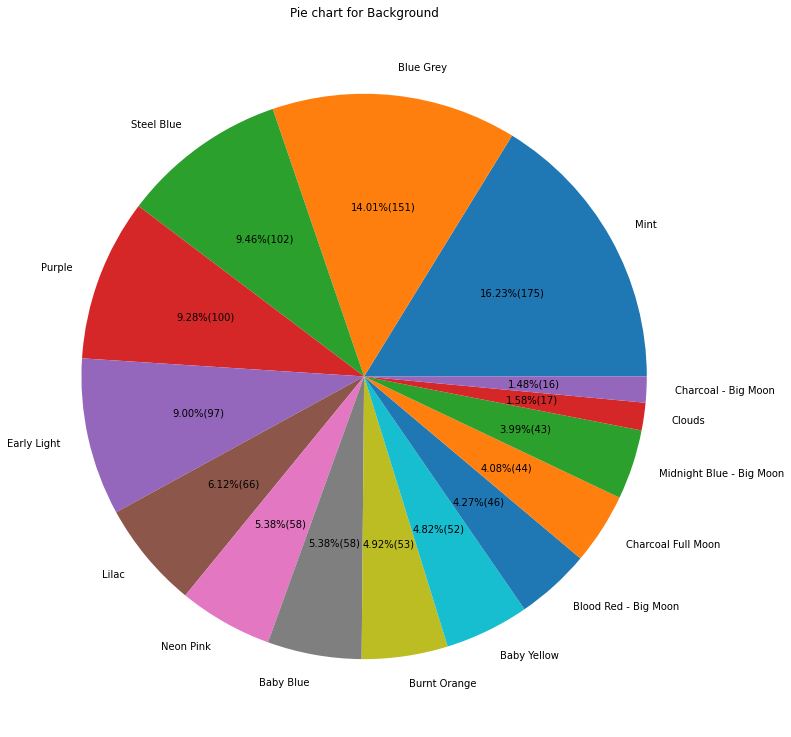

In [13]:
plt.figure()
values = background
values.plot(kind='pie',labels = list(background.index), title='Pie chart for Background', figsize=[13,13],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*values.sum()),ylabel = '')
plt.show()

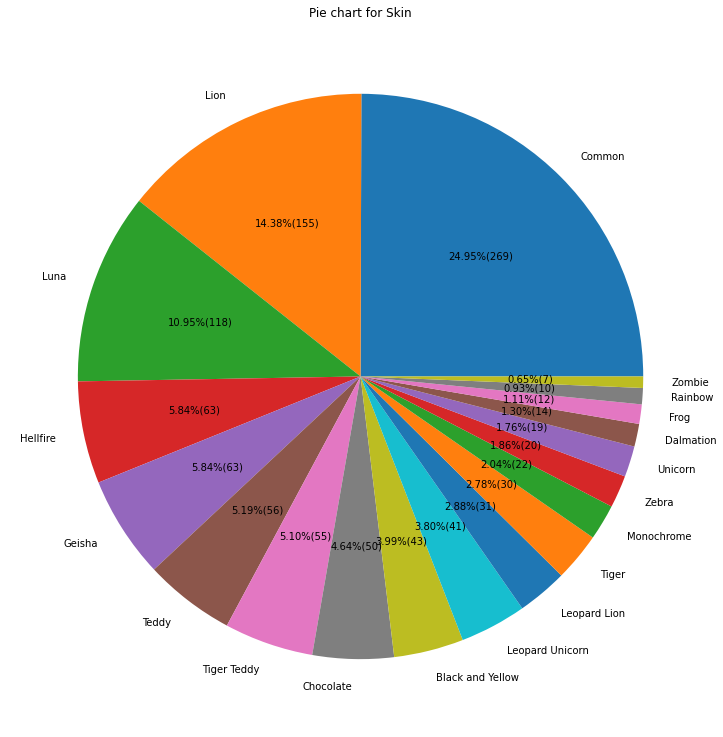

In [14]:
plt.figure()
values = skin
values.plot(kind='pie',labels = list(skin.index), title='Pie chart for Skin', figsize=[13,13],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*values.sum()),ylabel = '')
plt.show()

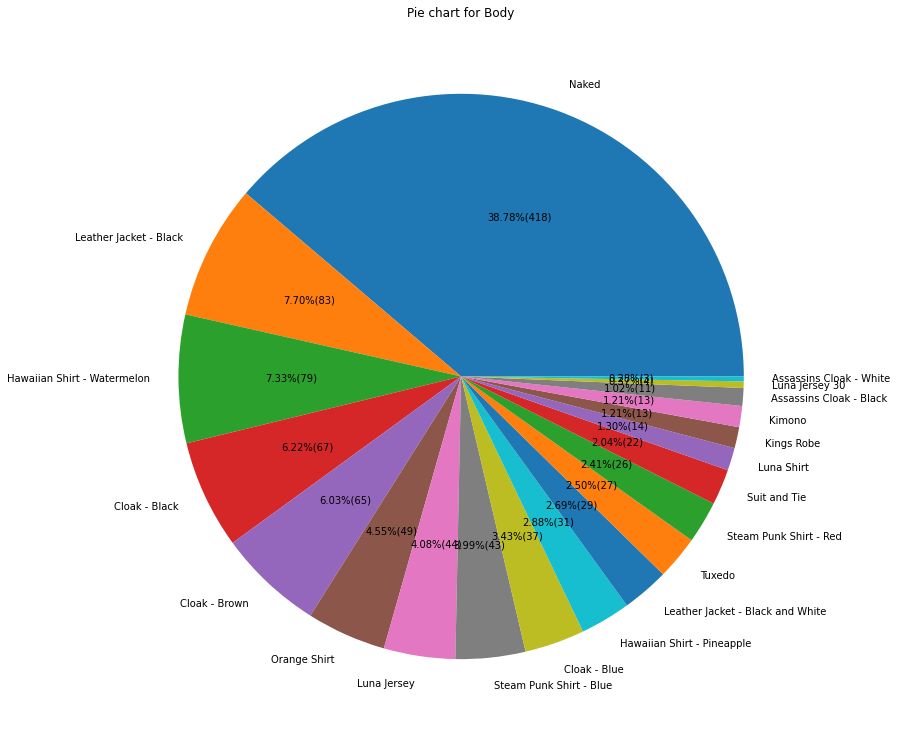

In [19]:
plt.figure()
values = body
values.plot(kind='pie',labels = list(body.index), title='Pie chart for Body', figsize=[13,13],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*values.sum()),ylabel = '')
plt.show()

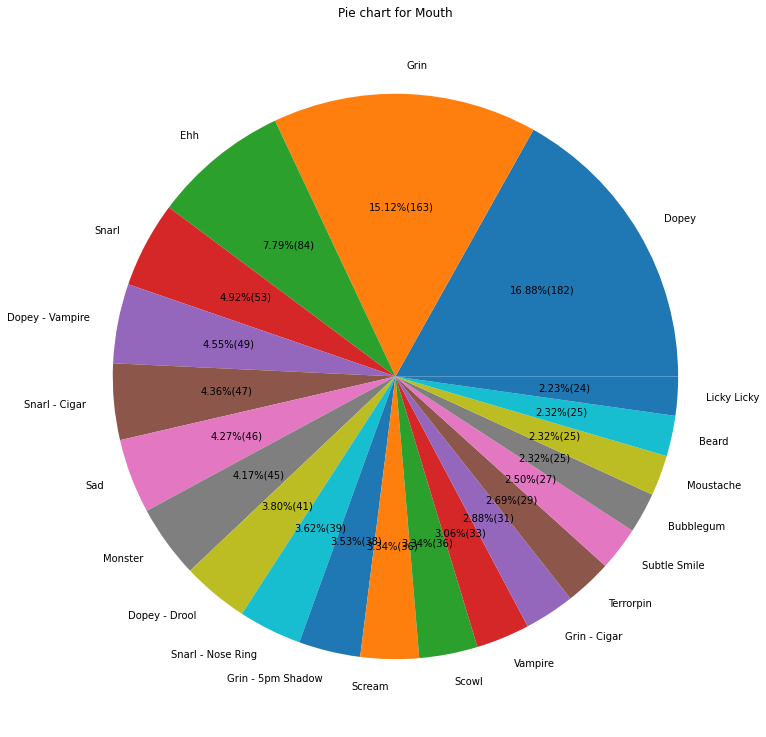

In [22]:
plt.figure()
values = mouth
values.plot(kind='pie',labels = list(mouth.index), title='Pie chart for Mouth', figsize=[13,13],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*values.sum()),ylabel = '')
plt.show()

In [24]:
"""Calculating different types of particular trait"""

lista_kolumn = list(df.columns)
for i in range(len(lista_kolumn)-1):
    print(len(df[lista_kolumn[i]].unique()), 'different types of', lista_kolumn[i])

1078 different types of Name
1078 different types of token_id
15 different types of Background
19 different types of Skin
20 different types of Shell
20 different types of Body
21 different types of Mouth
32 different types of Eyes
56 different types of Head
882 different types of Rarity score


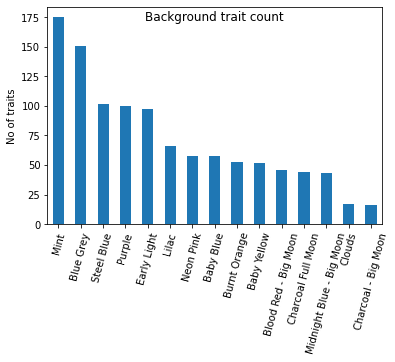

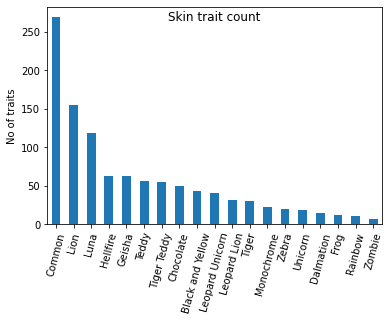

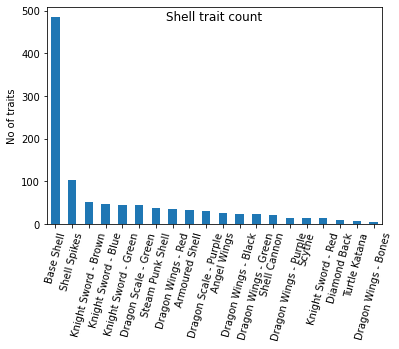

In [25]:
#some charts of trait count
plt.figure()
values_count[0].plot.bar(fontsize = 10,rot = 75)
plt.title('Background trait count', y=1.0, pad=-14)
plt.ylabel('No of traits')
plt.show()
values_count[1].plot.bar(fontsize = 10,rot = 75)
plt.title('Skin trait count', y=1.0, pad=-14)
plt.ylabel('No of traits')
plt.show()
values_count[2].plot.bar(fontsize = 10,rot = 75)
plt.title('Shell trait count', y=1.0, pad=-14)
plt.ylabel('No of traits')
plt.show()


In [26]:
df_price = df_transactions.groupby(["token_id"]).Price_in_luna.mean().reset_index()
df_tra = df_transactions.groupby(["token_id"]).Price_in_luna.count().reset_index()
df_tra = pd.DataFrame(data = df_tra)
df_price = pd.DataFrame(data = df_price)

dfqwe = df.set_index('token_id').join(df_tra.set_index('token_id'))
df_price_joined = df.set_index('token_id').join(df_price.set_index('token_id'))
dfqwe.dropna()
df_price_joined.dropna()
dfqwe = dfqwe.sort_values(['Rank'])
df_price_joined = df_price_joined[df_price_joined['Price_in_luna'] < 1000]

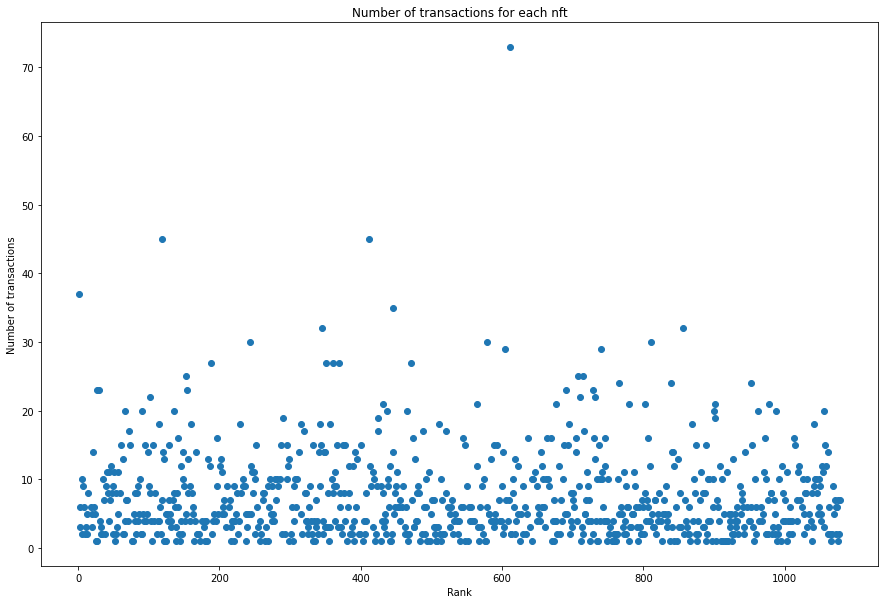

In [27]:
plt.plot(dfqwe["Rank"],dfqwe["Price_in_luna"],'o')
plt.xlabel('Rank')
plt.ylabel('Number of transactions')
plt.title("Number of transactions for each nft")
plt.gcf().set_size_inches(15, 10)
plt.show()

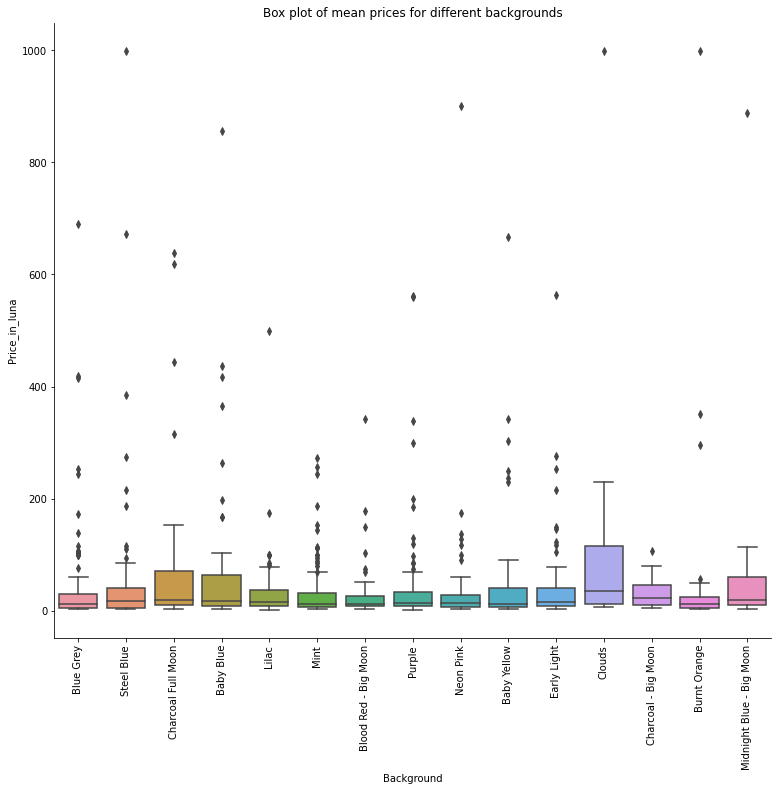

In [20]:
dataset_corr = df[['Background', 'Skin', 'Shell', 'Body',  'Mouth', 'Eyes', 'Head']]
sns.catplot(x='Background', y="Price_in_luna", kind="box", data=df_price_joined)
plt.xticks(rotation=90)
plt.title('Box plot of mean prices for different backgrounds')
plt.gcf().set_size_inches(15, 10)
plt.show()

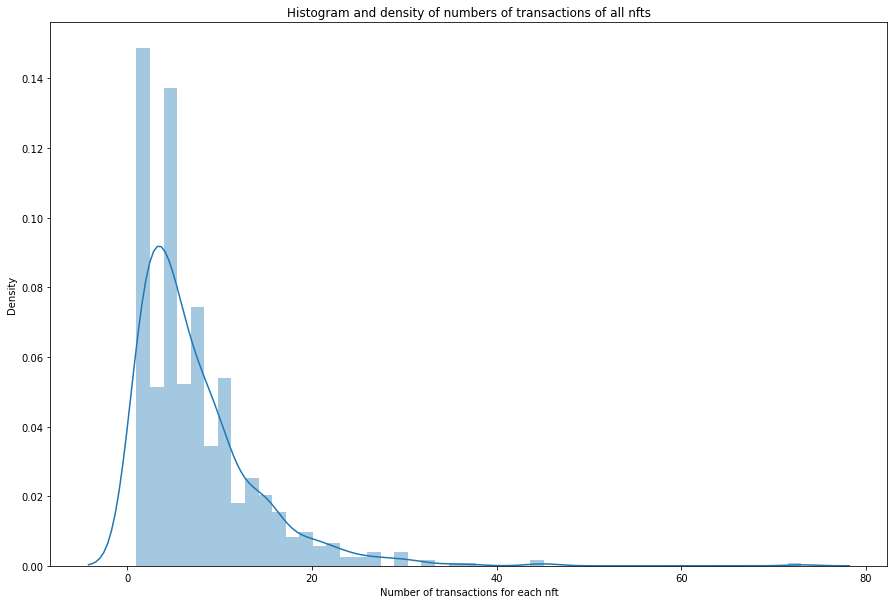

In [28]:
g = sns.distplot(dfqwe['Price_in_luna'])
plt.title('Histogram and density of numbers of transactions of all nfts')
plt.xlabel("Number of transactions for each nft")
plt.gcf().set_size_inches(15, 10)
plt.show()

# Conclusions

1. There are different number of categories for each trait,
2. We can see that rarity ranking doesnt really influence number of transactions,
3. Price in luna of most of transactions vary between 0 and 20, but vast majority is closer to 0,
4. Rariry ranking also doesn't affect price,
5. There are terrapins which have not been bought,
6. We can see that there are a lot of outliers when it comes to price,
7. There are some traits which increase the value of a terrapin, we can see on a boxplot that most of traits
doesnt affect value of terrapin and its mean value is close to zero, but for example in Shell traits there are 
categories in which mean value of price in lune is close to 200.